In [14]:
%load_ext autoreload
%autoreload 2

In [16]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Step 2: Load the dataset
path = 'data/raw/multi_attribution_sample.csv'
data = pd.read_csv(path)
data.head()

,Global Flag,Major Flag,SMC Flag,Commercial Flag,IT Spend,Employee Count,PC Count,Size,Tech Support,Discount,Revenue
0,1,0,1,0,45537,26,26,152205,0,1,17688.36300
1,0,0,1,1,20842,107,70,159038,0,1,14981.43559
2,0,0,0,1,82171,10,7,264935,1,1,32917.13894
3,0,0,0,0,30288,40,39,77522,1,1,14773.76855
4,0,0,1,0,25930,37,43,91446,1,1,17098.69823


# Identifying the causal estimand

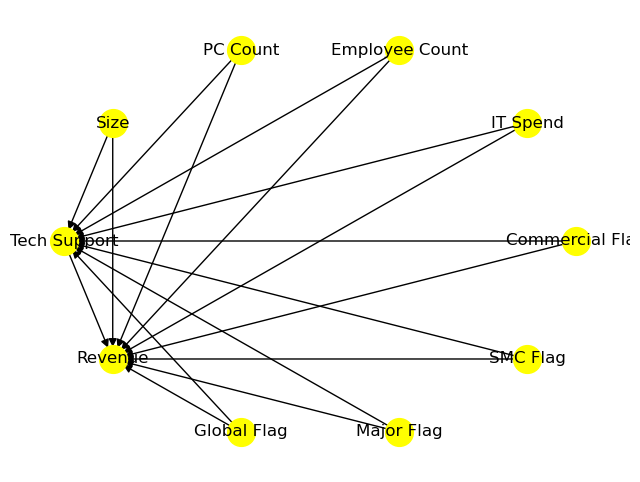

In [25]:
# Define variables
covariates = ['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag', 'IT Spend', 'Employee Count', 'PC Count', 'Size']
outcome = 'Revenue'
treatment = 'Tech Support'

data['Tech Support'] = data['Tech Support'].astype(bool)

# Define effect modifiers (variables over which treatment effect may vary)
effect_modifiers = covariates.copy()

model=CausalModel(
    data = data,
    treatment=treatment,
    outcome=outcome,
    common_causes=covariates,
    effect_modifiers=effect_modifiers
)

model.view_model()

In [12]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                       ↪
───────────────(E[Revenue|Commercial Flag,Employee Count,Global Flag,Major Fla ↪
d[Tech Support]                                                                ↪

↪                                    
↪ g,Size,PC Count,SMC Flag,IT Spend])
↪                                    
Estimand assumption 1, Unconfoundedness: If U→{Tech Support} and U→Revenue then P(Revenue|Tech Support,Commercial Flag,Employee Count,Global Flag,Major Flag,Size,PC Count,SMC Flag,IT Spend,U) = P(Revenue|Tech Support,Commercial Flag,Employee Count,Global Flag,Major Flag,Size,PC Count,SMC Flag,IT Spend)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



# Method 1: Regression

In [17]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag', 'IT Spend', 'Employee Count', 'PC Count', 'Size']}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                       ↪
───────────────(E[Revenue|Commercial Flag,Employee Count,Global Flag,Major Fla ↪
d[Tech Support]                                                                ↪

↪                                    
↪ g,Size,PC Count,SMC Flag,IT Spend])
↪                                    
Estimand assumption 1, Unconfoundedness: If U→{Tech Support} and U→Revenue then P(Revenue|Tech Support,Commercial Flag,Employee Count,Global Flag,Major Flag,Size,PC Count,SMC Flag,IT Spend,

# Method 2: Distance Matching

In [26]:
causal_estimate_dmatch = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.distance_matching",
                                            #   target_units=treatment,
                                              method_params={'distance_metric':"minkowski", 'p':2})
print(causal_estimate_dmatch)
print("Causal Estimate is " + str(causal_estimate_dmatch.value))

distance_matching
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                       ↪
───────────────(E[Revenue|Commercial Flag,Employee Count,Global Flag,Major Fla ↪
d[Tech Support]                                                                ↪

↪                                    
↪ g,Size,PC Count,SMC Flag,IT Spend])
↪                                    
Estimand assumption 1, Unconfoundedness: If U→{Tech Support} and U→Revenue then P(Revenue|Tech Support,Commercial Flag,Employee Count,Global Flag,Major Flag,Size,PC Count,SMC Flag,IT Spend,U) = P(Revenue|Tech Support,Commercial Flag,Employee Count,Global Flag,Major Flag,Size,PC Count,SMC Flag,IT Spend)

## Realized estimand
b: Revenue~Tech Support+Commercial Flag+Employee Count+Global Flag+Major Flag+Size+PC Count+SMC Flag+IT Spend
Target units: ate

## Estimate
Mean value: 7

# Method 3: Propensity Score Stratification

In [28]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="att")
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

propensity_score_stratification
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                       ↪
───────────────(E[Revenue|Commercial Flag,Employee Count,Global Flag,Major Fla ↪
d[Tech Support]                                                                ↪

↪                                    
↪ g,Size,PC Count,SMC Flag,IT Spend])
↪                                    
Estimand assumption 1, Unconfoundedness: If U→{Tech Support} and U→Revenue then P(Revenue|Tech Support,Commercial Flag,Employee Count,Global Flag,Major Flag,Size,PC Count,SMC Flag,IT Spend,U) = P(Revenue|Tech Support,Commercial Flag,Employee Count,Global Flag,Major Flag,Size,PC Count,SMC Flag,IT Spend)

## Realized estimand
b: Revenue~Tech Support+Commercial Flag+Employee Count+Global Flag+Major Flag+Size+PC Count+SMC Flag+IT Spend
Target units: att

## Estimate

# Method 4: Propensity Score Matching

In [30]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="atc")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

propensity_score_matching
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                       ↪
───────────────(E[Revenue|Commercial Flag,Employee Count,Global Flag,Major Fla ↪
d[Tech Support]                                                                ↪

↪                                    
↪ g,Size,PC Count,SMC Flag,IT Spend])
↪                                    
Estimand assumption 1, Unconfoundedness: If U→{Tech Support} and U→Revenue then P(Revenue|Tech Support,Commercial Flag,Employee Count,Global Flag,Major Flag,Size,PC Count,SMC Flag,IT Spend,U) = P(Revenue|Tech Support,Commercial Flag,Employee Count,Global Flag,Major Flag,Size,PC Count,SMC Flag,IT Spend)

## Realized estimand
b: Revenue~Tech Support+Commercial Flag+Employee Count+Global Flag+Major Flag+Size+PC Count+SMC Flag+IT Spend
Target units: atc

## Estimate
Mean 

# Method 5: Weighting

In [31]:
causal_estimate_ipw = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"})
print(causal_estimate_ipw)
print("Causal Estimate is " + str(causal_estimate_ipw.value))

propensity_score_weighting
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                       ↪
───────────────(E[Revenue|Commercial Flag,Employee Count,Global Flag,Major Fla ↪
d[Tech Support]                                                                ↪

↪                                    
↪ g,Size,PC Count,SMC Flag,IT Spend])
↪                                    
Estimand assumption 1, Unconfoundedness: If U→{Tech Support} and U→Revenue then P(Revenue|Tech Support,Commercial Flag,Employee Count,Global Flag,Major Flag,Size,PC Count,SMC Flag,IT Spend,U) = P(Revenue|Tech Support,Commercial Flag,Employee Count,Global Flag,Major Flag,Size,PC Count,SMC Flag,IT Spend)

## Realized estimand
b: Revenue~Tech Support+Commercial Flag+Employee Count+Global Flag+Major Flag+Size+PC Count+SMC Flag+IT Spend
Target units: ate

## Estimate
Mean

# Method 6: Instrumental Variable

In [33]:
causal_estimate_iv = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", method_params = {'iv_instrument_name': 'Z0'})
print(causal_estimate_iv)
print("Causal Estimate is " + str(causal_estimate_iv.value))

instrumental_variable
Estimation failed! No relevant identified estimand available for this estimation method.
Causal Estimate is None


In [34]:
# Method 7: Regression Discontinuity

In [35]:
causal_estimate_regdist = model.estimate_effect(identified_estimand,
        method_name="iv.regression_discontinuity", 
        method_params={'rd_variable_name':'Z1',
                       'rd_threshold_value':0.5,
                       'rd_bandwidth': 0.15})
print(causal_estimate_regdist)
print("Causal Estimate is " + str(causal_estimate_regdist.value))

regression_discontinuity
Estimation failed! No relevant identified estimand available for this estimation method.
Causal Estimate is None
